In [11]:
%matplotlib inline
%pwd

'/home/gabe/work/fast-ai/nbs'

In [12]:
%%html
<style>
  .end_space {
      min-height: 1000px;
  }
  .container {
      width: 100%;
  }
</style

In [62]:
import sys
import os
import tarfile
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy

from scipy.ndimage.interpolation import shift
from pandas.plotting import scatter_matrix
from six.moves import urllib
from importlib import reload
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from os import listdir, makedirs
from os.path import join, abspath, exists, isdir, isfile

np.random.seed(seed=2017)
sys.path.append('../src')

In [14]:
import utils.utils
reload(utils.utils)

import utils.train_helper
reload(utils.train_helper)

import utils.mix_iterator
reload(utils.mix_iterator)

import utils.housing_helper
reload(utils.housing_helper)

from utils.train_helper import save_model, read_model, get_classes, get_batches, get_data, un_onehot
from utils.utils import save_array, load_array, read_img, get_steps, do_clip, mkdir
from utils.mix_iterator import MixIterator
from utils.housing_helper import CombinedAttributesAdder, DataFrameSelector, CategoricalEncoder

In [15]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam, Nadam
from keras.regularizers import l2
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import xception, inception_v3
from keras.utils import to_categorical as onehot

from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, confusion_matrix, precision_score
from sklearn.metrics import precision_recall_curve, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.externals import joblib
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier

In [16]:
DATA_DIR = '../data/mnist'
mkdir(DATA_DIR)

In [17]:
# mnist = fetch_mldata('MNIST original')
# joblib.dump(mnist, join(DATA_DIR, 'mnist.data'))
# mnist

In [18]:
mnist = joblib.load(join('../data/', 'mnist.data'))
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [19]:
X, y = mnist.data, mnist.target
print(X.shape, y.shape)

(70000, 784) (70000,)


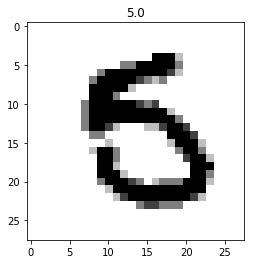

In [73]:
some_digit_index = 32000
some_digit = X[some_digit_index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.title(y[some_digit_index])
plt.show()

In [21]:
SPLIT = 60000
X_train, X_test, y_train, y_test = X[:SPLIT], X[SPLIT:], y[:SPLIT], y[SPLIT:]

shuffle_index = np.random.permutation(SPLIT)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42, max_iter=5)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [23]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### Measure accuracy using cross-validation

In [24]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9688
0.96485
0.95175


In [25]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9688 ,  0.96485,  0.95175])

In [26]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[54168,   411],
       [ 1881,  3540]])

In [27]:
print('the classifier is correct %.2f%% of the time' % (precision_score(y_train_5, y_train_pred) * 100))
print('the classifier detects %.2f%% of correct values' % (recall_score(y_train_5, y_train_pred) * 100))

the classifier is correct 89.60% of the time
the classifier detects 65.30% of correct values


In [28]:
f1_score(y_train_5, y_train_pred)

0.7554417413572343

In [29]:
sgd_clf.decision_function([some_digit])

array([ 184649.55298628])

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

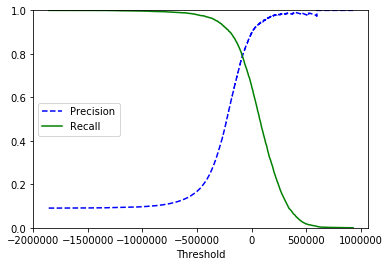

In [32]:
y_scores_raw = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores = y_scores_raw[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

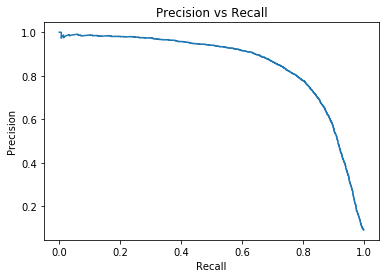

In [33]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.show()

0.963643651966


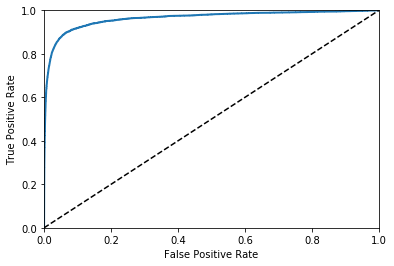

In [34]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
print(roc_auc_score(y_train_5, y_scores))
plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]

0.992619893405


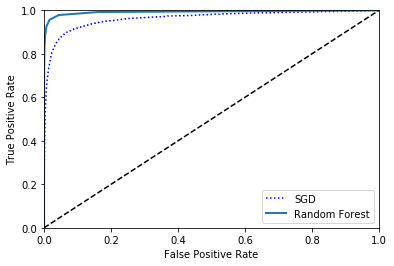

In [36]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
print(roc_auc_score(y_train_5, y_scores_forest))
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

## Multiclass classifier

In [37]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [38]:
print(sgd_clf.decision_function([some_digit]), 'decision function')
print(sgd_clf.classes_, 'classes')

[[-368838.9589356  -587646.04645386 -565505.45884937 -511763.12671407
  -434482.62562561  184649.55298628  -83006.38656402 -938138.54362691
  -216968.49142407 -785213.584415  ]] decision function
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.] classes


In [39]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [40]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.83168366,  0.85354268,  0.86017903])

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([ 0.90756849,  0.91114556,  0.90943642])

### Error analysis

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5722,    3,   27,   10,   10,   51,   48,    8,   39,    5],
       [   2, 6455,   47,   23,    5,   44,    6,   13,  134,   13],
       [  59,   40, 5333,   96,   85,   23,   86,   66,  155,   15],
       [  43,   41,  127, 5352,    3,  245,   34,   56,  134,   96],
       [  17,   25,   38,    9, 5334,   10,   52,   31,   81,  245],
       [  67,   34,   35,  182,   68, 4614,  109,   24,  191,   97],
       [  33,   19,   41,    2,   44,   96, 5623,    4,   54,    2],
       [  24,   19,   68,   29,   53,   11,    6, 5789,   18,  248],
       [  50,  143,   74,  166,   14,  154,   52,   22, 5017,  159],
       [  40,   26,   31,   84,  147,   31,    3,  186,   77, 5324]])

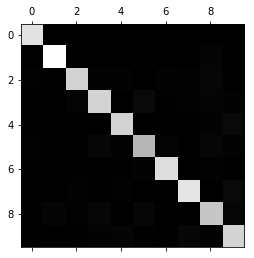

In [44]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

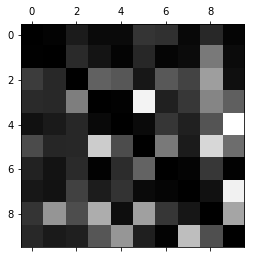

In [45]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [67]:
def plot_digit(digit_image, title=None):
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.title(title)

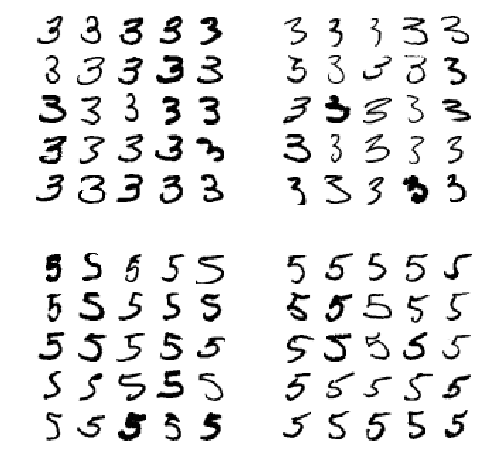

In [47]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & ( y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & ( y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & ( y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & ( y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel classification

In [48]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [49]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [50]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average='macro')

### Multioutput classification

In [51]:
noise_train = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise_train

noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test

y_train_mod = X_train
y_test_mod = X_test

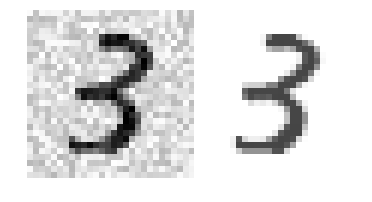

In [78]:
plot_digits([X_train_mod[some_digit_index], y_train_mod[some_digit_index]])
plt.show()

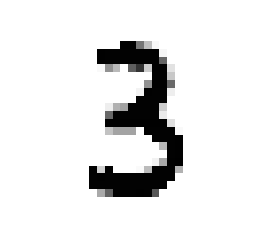

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[4000]])
plot_digits([clean_digit])
plt.show()

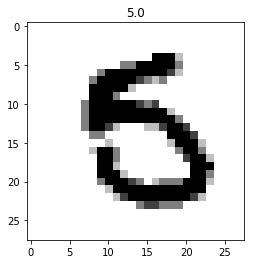

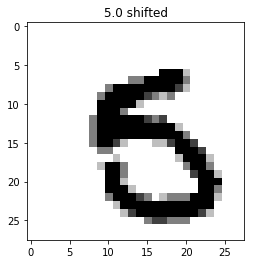

In [81]:
some_digit_image_shifted = shift(some_digit_image, [2, 1])
plot_digit(some_digit_image, y[some_digit_index])
plt.show()
plot_digit(some_digit_image_shifted, '%.1f shifted' % y[some_digit_index])
plt.show()

In [ ]:
np.dot(np.array([1,2,4]), np.array([4,5,6])